# Assigment 3

In [1]:
# Import the required libraries
import taurex
import numpy as np
import matplotlib.pyplot as plt
from taurex.cache import OpacityCache,CIACache
import json
import pickle
import h5py
# Set general paths
path_to_cia = "./cia/hitran/"
path_to_xsec = "./xsecs/"

# Setup paths
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(path_to_xsec)
CIACache().set_cia_path(path_to_cia)

## Task A

Generate a transmission spectrum with TauREx. Use the planet you choose in assignment 2 – Task A for the planetary and stellar parameters. Put H2O, CH4, CO2 and CO in the atmosphere; their abundances should be randomised within $[10^{-8}, 10^{-2}]$. Submit the transmission spectrum in a file called [planet_name]_assignment3_taskA_spectrum.dat with three columns (wavelength in micron, $(rp/rs)^2$, $\sqrt{(rp/rs)^2}$), plot it in a file called [planet_name]_assignment3_taskA_spectrum.png and report the forward model parameters in a file called [planet_name]_assignment3_taskA_parameters.txt

In [2]:
# We choose HAT-P-18b
HAT_P_18b_PARAMS = {
    "time_of_conjunction": 0.0,               # Time of inferior conjunction (days)
    "orbital_period": 5.508,                  # Orbital period (days)
    "planet_radius": 0.995,                   # Planet radius (Jupiter radii)
    "semi_major_axis": 16.04,                 # Semi-major axis (in units of stellar radii)
    "orbital_inclination": 88.8,              # Orbital inclination (degrees)
    "orbital_eccentricity": 0.084,            # Orbital eccentricity
    "longitude_of_periastron": 120.0,         # Longitude of periastron (degrees)
    "planet_mass": 0.197,                       # Planet Mass (Jupiter Mass)
    "star_temperature": 4803,                 # Kelvin
    "star_radius": 0.765,                      # Stellar Radius (Solar Radii)
    "atm_min_pressure": 1,
    "atm_max_pressure": 1e6,
    "equilibrium_temperature": 852,            # Planet equilibrium temperature in Kelvin
    "stellar_mass": 0.770,                       # Solar Mass
    "stellar_metallicity": 0.10,                 
    
}

# Now  we randomize the abundances of the molecules composing this planet
H2O = np.random.uniform(1e-8,1e-2)
print(f"H2O: {H2O:.3e}")
CH4 = np.random.uniform(1e-8,1e-2)
print(f"CH4: {CH4:.3e}")
CO2 = np.random.uniform(1e-8,1e-2)
print(f"CO2: {CO2:.3e}")
CO = np.random.uniform(1e-8,1e-2)
print(f"CO: {CO:.3e}")

# We add them to the parameter list
HAT_P_18b_PARAMS["H2O"] = H2O
HAT_P_18b_PARAMS["CH4"] = CH4
HAT_P_18b_PARAMS["CO2"] = CO2
HAT_P_18b_PARAMS["CO"] = CO

# Save parameters
with open('HAT_P_18b_assignment3_taskA_parameters.json', 'w') as file:
    json.dump(HAT_P_18b_PARAMS, file, indent=4)


H2O: 3.982e-03
CH4: 9.856e-03
CO2: 5.824e-03
CO: 7.569e-03


In [3]:
# Import Taurex Relevant Functions
from taurex.temperature import Guillot2010
from taurex.planet import Planet
from taurex.stellar import BlackbodyStar
from taurex.chemistry import TaurexChemistry
from taurex.model import TransmissionModel
from taurex.contributions import AbsorptionContribution
from taurex.contributions import CIAContribution
from taurex.contributions import RayleighContribution
from taurex.chemistry import ConstantGas
from taurex.binning import FluxBinner,SimpleBinner

In [4]:
# Define our model
temperature_profile = Guillot2010(T_irr=HAT_P_18b_PARAMS["equilibrium_temperature"])
planet = Planet(planet_mass = HAT_P_18b_PARAMS["planet_mass"], planet_radius = HAT_P_18b_PARAMS["planet_radius"])
star = BlackbodyStar(temperature=HAT_P_18b_PARAMS["star_temperature"], radius=HAT_P_18b_PARAMS["star_radius"], mass=HAT_P_18b_PARAMS["stellar_mass"],metallicity=HAT_P_18b_PARAMS["stellar_metallicity"])
chemistry = TaurexChemistry()
chemistry.addGas(ConstantGas('H2O',mix_ratio=np.power(10, -4.47)))
# chemistry.addGas(ConstantGas('CH4',mix_ratio=CH4))
chemistry.addGas(ConstantGas('CO2',mix_ratio=np.power(10, -4.86)))
# chemistry.addGas(ConstantGas('CO',mix_ratio=CO))
chemistry.addGas(ConstantGas("Na", mix_ratio=np.power(10, -6.99)))

# "H2O": np.power(10, -4.47),  # Water vapor abundance
# "CO2": np.power(10, -4.86),  # Carbon dioxide abundance
# "Na": np.power(10, -6.99),   # Sodium abundance

model = TransmissionModel(planet=planet,
                       temperature_profile=temperature_profile,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

model.add_contribution(AbsorptionContribution())
model.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
model.add_contribution(RayleighContribution())

model.build()
results = model.model()

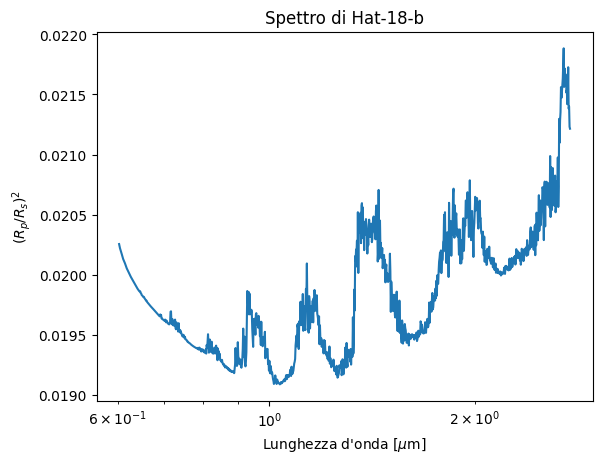

In [5]:
binned_fig = plt.figure()
#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.22,0.44,1000))
bn = FluxBinner(wngrid=wngrid)
bin_wn, bin_rprs,_,_  = bn.bin_model(model.model(wngrid=wngrid))
plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.title("Spettro di Hat-18-b")
plt.xlabel('Lunghezza d\'onda [$\\mu$m]')
plt.ylabel(r'$(R_p / R_s)^2$')
plt.savefig('HAT_P_18b_assignment3_taskA_spectrum.png')
plt.show()

# Save the matrix
matrix = np.array([10000/bin_wn, bin_rprs, np.ones(bin_rprs.shape)*20e-6])
np.savetxt('HAT18b_assignment3_taskA_spectrum.dat', matrix.T)

# Task B

Choose a real known planet from https://exoplanetarchive.ipac.caltech.edu/cgi-bin/atmospheres/nph- firefly?atmospheres. Ideally, use the planet you picked up in assignment 2 (check if the following criteria are valid). Otherwise, use one of the planets in the archive, choosing the following criteria:
1) Select a transmission spectrum;
2) It should have a JWST observation;
3) Select a planet with a published article.


Write the transmission spectrum in a file called [planet_name]_spectrum_assignment3_taskB.dat with three columns (wavelength in micrometers, (rp/rs)^2, and error). Plot the spectrum and store it in a file called [planet_name]_spectrum_assignment3.png. Report the physical parameters of the system (star + planet) and the reported chemistry of the atmosphere in the related paper in a file [planet_name]_[article_name]_report_assignment3_TaskB.txt

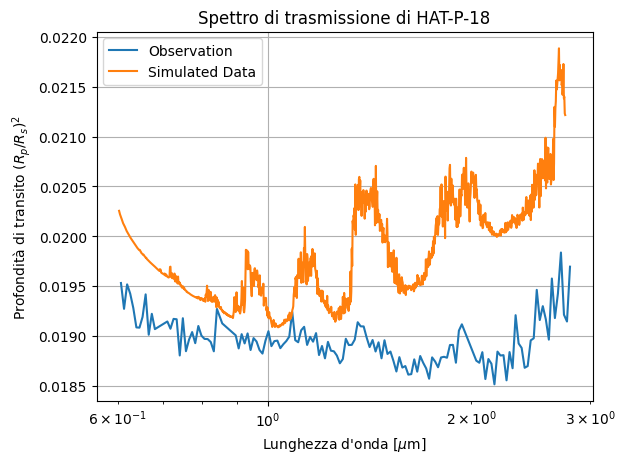

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

df = pd.read_csv('/home/ubuntu/comp_astro_24/Assigments/Assigment 3/HAT18P_139points.csv')

df = df[['CENTRALWAVELNG', 'BANDWIDTH', 'PL_TRANDEP', 'PL_TRANDEPERR1']]
df["PL_TRANDEP"] = df["PL_TRANDEP"] / 100
df['PL_TRANDEPERR1'] = df['PL_TRANDEPERR1']**2
df.to_csv('/home/ubuntu/comp_astro_24/Assigments/Assigment 3/HATP18_spectrum_assignment3_taskB.csv')
np.savetxt('HATP18_spectrum_assignment3_taskB.dat', df[['CENTRALWAVELNG', 'PL_TRANDEP', 'PL_TRANDEPERR1']].to_numpy())
# Estrai i dati per il plot
wavelength = df['CENTRALWAVELNG']  # Lunghezza d'onda in micron
wavelength_error = df['BANDWIDTH'] # Errore su lunghezza d'onda
transit_depth = df['PL_TRANDEP']   # Profondità di transito (Rp/Rs)^2
error = df['PL_TRANDEPERR1']       # Errore sulla profondità di transito

# Crea una figura più larga
plt.figure()  # Aumenta il valore della larghezza (primo parametro)

# Crea il grafico dello spettro
#plt.errorbar(wavelength, transit_depth, xerr=wavelength_error, yerr=error, fmt='o', markersize=4, capsize=2, label='Dati osservati')
plt.plot(wavelength,transit_depth, label="Observation")
# Configura il grafico
plt.xlabel('Lunghezza d\'onda [$\\mu$m]')
plt.ylabel('Profondità di transito $(R_p / R_s)^2$')
plt.title('Spettro di trasmissione di HAT-P-18')
plt.xscale('log')
plt.plot(10000/bin_wn,bin_rprs, label="Simulated Data")
plt.grid(True)
plt.legend()

# Salva il grafico in un file PNG
plt.savefig('/home/ubuntu/comp_astro_24/Assigments/Assigment 3/HATP18_spectrum_assignment3.png', dpi=300)

# Mostra il grafico
plt.show()

In [7]:
# Update the abundances

REAL_HAT_P_18b_PARAMS = HAT_P_18b_PARAMS
REAL_HAT_P_18b_PARAMS.update({
    "H2O": np.power(10, -4.47),  # Water vapor abundance
    "CO2": np.power(10, -4.86),  # Carbon dioxide abundance
    "Na": np.power(10, -6.99),   # Sodium abundance
})
# Save to file
with open('HATP18b_NearInfraredTransmission_report_assignment3_taskb.json', 'w') as file:
    json.dump(REAL_HAT_P_18b_PARAMS, file, indent=4)


# Task C

Perform an atmospheric retrieval of the synthetic spectrum of point A. Retrieve the molecular abundances for all the molecules in point A, together with the temperature and the radius of the planet (if it is computationally intense, use the virtual machine in CloudVeneto, or fix the parameters and try to retrieve at least H2O, the radius and the temperature of the planet). Plot the posterior distribution of the retrieved parameters and compare the input parameters with the retrieved spectrum. Write a submission file called assignment3_taskC.txt where you put all the input parameters of the planet, the retrieved parameters and the error bars. Plot them visually in a scatter point called assignment3_taskC.png (and label each point)

In [8]:
from taurex.optimizer.nestle import NestleOptimizer
from taurex.data.spectrum.observed import ObservedSpectrum
opt = NestleOptimizer(num_live_points=200)

opt.set_model(model)
obs = ObservedSpectrum("HAT18b_assignment3_taskA_spectrum.dat")
opt.set_observed(obs)
obin = obs.create_binner()

# Define parameters to fit
opt.enable_fit('planet_radius')
opt.set_boundary('planet_radius',[0.8,1.2])

opt.enable_fit("T_irr")
opt.set_boundary('T_irr',[750,950])

opt.enable_fit("H2O")
opt.set_boundary('H2O',[1e-4,1e-5])

opt.enable_fit("CO2")
opt.set_boundary('CO2',[1e-4,1e-5])

opt.enable_fit("Na")
opt.set_boundary('Na',[1e-6,1e-8])

In [9]:
# Perform the fit
DO_FIT = False

if DO_FIT:
    solution = opt.fit()
    taurex.log.disableLogging()
    with open('Retrieval_Simulated_Solution.pkl', 'wb') as file:  # Use 'wb' for write binary mode
        for data in opt.get_solution():
            pickle.dump(data, file)
else:
    with open('Retrieval_Simulated_Solution.pkl', 'rb') as file:  # Use 'wb' for write binary mode
        data = pickle.load(file)


In [10]:
solution,optimized_map,optimized_value,values = data
sol = values[1][1]
for key in sol.keys():
    print(f"{key}",sol[key]["value"])
    
task_C = {}
task_C["input_parameters"] = HAT_P_18b_PARAMS
task_C["retrieved_parameters"] = {}
for key in sol.keys():
    task_C["retrieved_parameters"][key] = {}
    task_C["retrieved_parameters"][key]["mean"] = sol[key]["mean"]
    task_C["retrieved_parameters"][key]["sigma"] = np.mean(sol[key]["sigma"])
    
with open('assignment3_taskC.json', 'w') as file:
    json.dump(task_C, file, indent=4)

planet_radius 0.9950029904533182
T_irr 851.8996858239229
log_H2O -4.469758904676951
log_CO2 -4.8594771638681395
log_Na -6.989526782620543


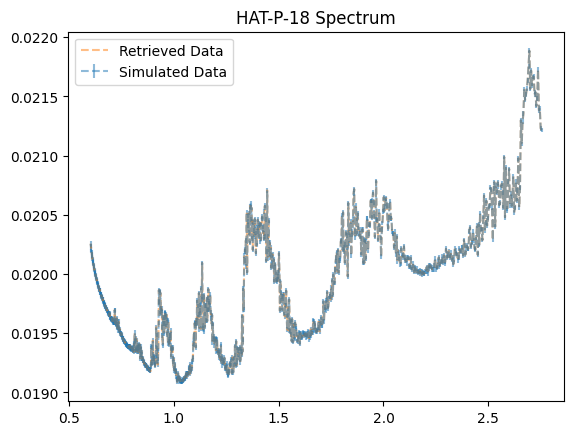

<Figure size 640x480 with 0 Axes>

In [11]:
# NOT SURE IF THIS IS WHAT HE WANTS

solution,optimized_map,optimized_value,values = data
opt.update_model(optimized_map)
plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Simulated Data', alpha=0.5, linestyle="dashed")
plt.plot(obs.wavelengthGrid,obin.bin_model(model.model(obs.wavenumberGrid))[1],label='Retrieved Data', linestyle="dashed", alpha = 0.5)
plt.title("HAT-P-18 Spectrum")
plt.legend()
plt.show()
plt.savefig("assignment3_taskC.png")

# Task D
Perform an atmospheric retrieval of the real spectrum of point B. Retrieve the molecular abundances of all the molecules in point A, together with the temperature and the radius of the planet (if it is computationally intense, use the virtual machine in CloudVeneto, or fix the parameters and try to retrieve at least H2O, the radius and the temperature of the planet). Plot the posterior
distribution of the retrieved parameters and compare the input parameters with the retrieved spectrum (if applicable). Write a submission file called assignment3_taskD.txt, where you distinguish all the fixed and retrieved parameters with their error bars.

In [12]:
# Create new model

# Define our model
temperature_profile = Guillot2010(T_irr=REAL_HAT_P_18b_PARAMS["equilibrium_temperature"])
planet = Planet(planet_mass = REAL_HAT_P_18b_PARAMS["planet_mass"], planet_radius = REAL_HAT_P_18b_PARAMS["planet_radius"])
star = BlackbodyStar(temperature=REAL_HAT_P_18b_PARAMS["star_temperature"], radius=REAL_HAT_P_18b_PARAMS["star_radius"])
chemistry = TaurexChemistry()
chemistry.addGas(ConstantGas('H2O',mix_ratio=REAL_HAT_P_18b_PARAMS["H2O"]))
chemistry.addGas(ConstantGas('Na',mix_ratio=REAL_HAT_P_18b_PARAMS["Na"]))
chemistry.addGas(ConstantGas('CO2',mix_ratio=REAL_HAT_P_18b_PARAMS["CO2"]))

model = TransmissionModel(planet=planet,
                       temperature_profile=temperature_profile,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

model.add_contribution(AbsorptionContribution())
model.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
model.add_contribution(RayleighContribution())

model.build()
results = model.model()

In [13]:
from taurex.optimizer.nestle import NestleOptimizer
from taurex.data.spectrum.observed import ObservedSpectrum
opt = NestleOptimizer(num_live_points=50)

opt.set_model(model)
obs = ObservedSpectrum("HATP18_spectrum_assignment3_taskB.dat")
opt.set_observed(obs)
obin = obs.create_binner()

# Define parameters to fit
opt.enable_fit('planet_radius')
opt.set_boundary('planet_radius',[0.8,1.2])

opt.enable_fit("T_irr")
opt.set_boundary('T_irr',[750,950])

opt.enable_fit("H2O")
opt.set_boundary('H2O',[1e-4,1e-5])

opt.enable_fit("CO2")
opt.set_boundary('CO2',[1e-4,1e-5])

opt.enable_fit("Na")
opt.set_boundary('Na',[1e-6,1e-8])

In [14]:
# Perform the fit
DO_FIT = False

if DO_FIT:
    solution = opt.fit()
    taurex.log.disableLogging()
    with open('Retrieval_Real_Solution.pkl', 'wb') as file:  # Use 'wb' for write binary mode
        for data in opt.get_solution():
            pickle.dump(data, file)
else:
    with open('Retrieval_Real_Solution.pkl', 'rb') as file:  # Use 'wb' for write binary mode
        data = pickle.load(file)


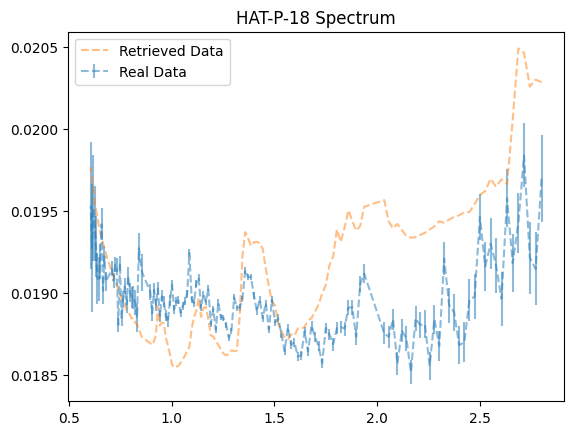

In [15]:
# NOT SURE IF THIS IS WHAT HE WANTS
solution,optimized_map,optimized_value,values = data
opt.update_model(optimized_map)
plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Real Data', alpha=0.5, linestyle="dashed")
plt.plot(obs.wavelengthGrid,obin.bin_model(model.model(obs.wavenumberGrid))[1],label='Retrieved Data', linestyle="dashed", alpha = 0.5)
plt.title("HAT-P-18 Spectrum")
plt.legend()
plt.show()

In [16]:
solution,optimized_map,optimized_value,values = data
sol = values[1][1]
for key in sol.keys():
    print(f"{key}",sol[key]["value"])
    
task_C = {}
task_C["input_parameters"] = REAL_HAT_P_18b_PARAMS
task_C["retrieved_parameters"] = {}
for key in sol.keys():
    task_C["retrieved_parameters"][key] = {}
    task_C["retrieved_parameters"][key]["mean"] = sol[key]["mean"]
    task_C["retrieved_parameters"][key]["sigma"] = np.mean(sol[key]["sigma"])
    
with open('assignment3_taskD.json', 'w') as file:
    json.dump(task_C, file, indent=4)

planet_radius 0.9853862737342012
T_irr 752.5841892687909
log_H2O -4.985419199121316
log_Na -6.290249554420357
log_CO2 -4.903422558754765


In [17]:
print("Planet Radius",HAT_P_18b_PARAMS["planet_radius"])
print("Equilibrium Temperature", HAT_P_18b_PARAMS["equilibrium_temperature"])
print("log of H2O Abundance", np.log10(HAT_P_18b_PARAMS["H2O"]))
print("log of CO2 Abundance", np.log10(HAT_P_18b_PARAMS["CO2"]))
print("log of Na Abundance", np.log10(HAT_P_18b_PARAMS["CO"]))

Planet Radius 0.995
Equilibrium Temperature 852
log of H2O Abundance -4.47
log of CO2 Abundance -4.86
log of Na Abundance -2.1209375248332742


Text(0.5, 0.98, 'Posterior of Retrieved Parameters')

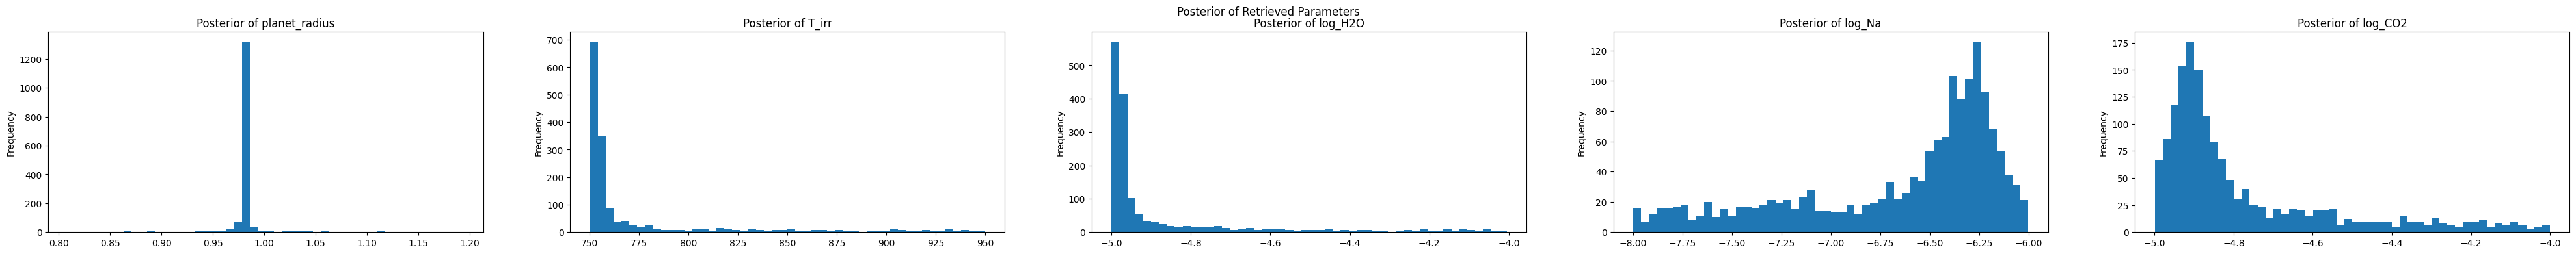

In [18]:
num_param = len(sol.keys())

fig, ax = plt.subplots(1,num_param, figsize=(10*num_param,4))

i = 0
for key in sol.keys():
    ax[i].hist(sol[key]["trace"],bins=50);
    ax[i].set_title(f"Posterior of {key}")
    ax[i].set_ylabel("Frequency")
    i+=1
fig.suptitle("Posterior of Retrieved Parameters")